In [2]:
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pylab as plt
import seaborn as sns

%matplotlib inline
sns.set(style='ticks', palette='Set2')

In [118]:
# Load data
df = pd.read_excel('Customer_Churn.xlsx').dropna()

# Transform non-target category variables into values:

    # COLLEGE = 0 if no, 1 if yes
df['COLLEGE'].replace(['zero','one'], 
                      [0,1], inplace=True)
    # REPORTED_SATISFACTION on a standard 1 = low, 5 = high scale
df['REPORTED_SATISFACTION'].replace(['very_unsat','unsat','avg','sat','very_sat'],                                [1,2,3,4,5], inplace=True)
    # REPORTED_USAGE_LEVEL on a standard 1 = low, 5 = high scale
df['REPORTED_USAGE_LEVEL'].replace(['very_little','little','avg','high','very_high'],
                                   [1,2,3,4,5], inplace=True)
    # CONSIDERING_CHANGE_OF_PLAN on a standard 1 = unlikely, 5 = likely scale
df['CONSIDERING_CHANGE_OF_PLAN'].replace(['never_thought','no','perhaps','considering','actively_looking_into_it'],
                                         [1,2,3,4,5], inplace=True)

# Rescale continuous variables to a value between 0 and 1 using min-max normalization
df['INCOME'] = (df['INCOME']-df['INCOME'].min())/(df['INCOME'].max()-df['INCOME'].min())
df['HOUSE'] = (df['HOUSE']-df['HOUSE'].min())/(df['HOUSE'].max()-df['HOUSE'].min())
df['OVERAGE'] = (df['OVERAGE']-df['OVERAGE'].min())/(df['OVERAGE'].max()-df['OVERAGE'].min())
df['HANDSET_PRICE'] = (df['HANDSET_PRICE']-df['HANDSET_PRICE'].min())/(df['HANDSET_PRICE'].max()-df['HANDSET_PRICE'].min())
df['AVERAGE_CALL_DURATION'] = (df['AVERAGE_CALL_DURATION']-df['AVERAGE_CALL_DURATION'].min()
                              )/(df['AVERAGE_CALL_DURATION'].max()-df['AVERAGE_CALL_DURATION'].min())
df['OVER_15MINS_CALLS_PER_MONTH'] = (df['OVER_15MINS_CALLS_PER_MONTH']-df['OVER_15MINS_CALLS_PER_MONTH'].min()
                                    )/(df['OVER_15MINS_CALLS_PER_MONTH'].max()-df['OVER_15MINS_CALLS_PER_MONTH'].min())

df.head()

# My hope is that by leaving the categories with wider distributions, the model will pick up more on any differences in them that might predict.

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,LEAVE
0,0,0.085343,0.005935,6,0.192208,0.040312,0.000000,0.214286,2,2,2,STAY
1,1,0.115305,0.005935,13,0.765398,0.148244,0.000000,0.357143,2,2,4,STAY
2,1,0.051909,0.688427,0,0.182410,0.092328,0.551724,1.000000,2,1,3,STAY
3,0,0.714858,0.118694,33,0.750868,0.845254,0.103448,0.071429,2,5,4,LEAVE
4,1,0.065783,0.623145,85,0.087979,0.144343,0.724138,0.000000,1,2,1,STAY


In [ ]:
#

LEAVE
LEAVE     9852
STAY     10148
dtype: int64
%LEAVE = 49.26


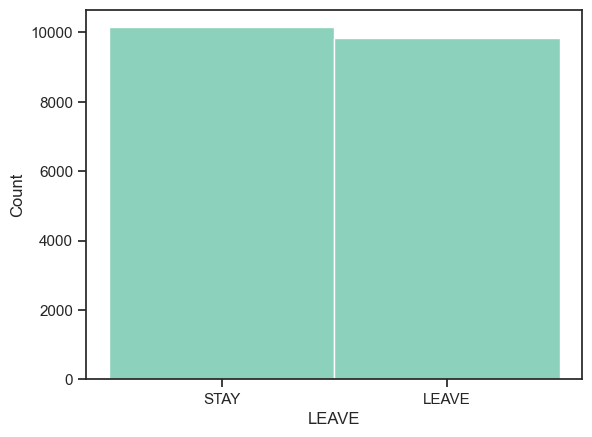

In [79]:
# View the target class distribution

print(df.groupby('LEAVE').size())
print('%LEAVE =', 100*(9852/20000))
sns.histplot(data=df, x=df['LEAVE'])
plt.show()

# The dataset is fairly balanced, with slightly more leave than stay.

In [ ]:
# Visualize difference between distribution for income

for r in range(2):
    hist = df[df.LEAVE == r].hist('INCOME')
    plt.title('Income where LEAVE =' + str(r))
    plt.show()

In [ ]:
# Visualize difference between distribution for overages

for r in range(2):
    hist = df[df.LEAVE == r].hist('OVERAGE')
    plt.title('Overages where LEAVE =' + str(r))
    plt.show()

In [ ]:
#Create a plot to see data alongside each other. This has an error I haven't resolved because I don't fully understand what it's doing.

# Column names
categorical_cols = ['COLLEGE','REPORTED_SATISFACTION','REPORTED_USAGE_LEVEL','CONSIDERING_CHANGE_OF_PLAN']
continuous_cols = ['INCOME','OVERAGE','LEFTOVER','HOUSE','HANDSET_PRICE','OVER_15MINS_CALLS_PER_MONTH','AVERAGE_CALL_DURATION']
target_col = 'LEAVE'
predictor_cols = categorical_cols + continuous_cols

rows = 2
fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(7*cols, 7*rows))
axs = axs.flatten()
posn = 0

# Plot continuous features
for col in continuous_cols:
    sns.boxplot(data=df, x=target_col, y=col, ax=axs[posn])
    axs[posn].set_ylabel(col)
    axs[posn].set_title('')
    posn+=1

In [119]:
from sklearn.tree import DecisionTreeClassifier

predictor_cols = ['COLLEGE','REPORTED_SATISFACTION','REPORTED_USAGE_LEVEL','CONSIDERING_CHANGE_OF_PLAN',
                  'INCOME','OVERAGE','LEFTOVER','HOUSE','HANDSET_PRICE','OVER_15MINS_CALLS_PER_MONTH','AVERAGE_CALL_DURATION']
decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=8)
decision_tree.fit(df[predictor_cols],df['LEAVE'])

DecisionTreeClassifier(criterion='entropy', max_depth=8)

In [ ]:
# Get a sense for the decision tree with a text representation

text_representation = tree.export_text(decision_tree)
print(text_representation)

In [ ]:
from sklearn import tree

fig = plt.figure(figsize=(150,25))
_=tree.plot_tree(decision_tree, feature_names=predictor_cols, class_names=df['LEAVE'].astype('str'), filled=True, fontsize=12)
fig.savefig('decision_tree_entropy.png')

# This plot is only showing stay.

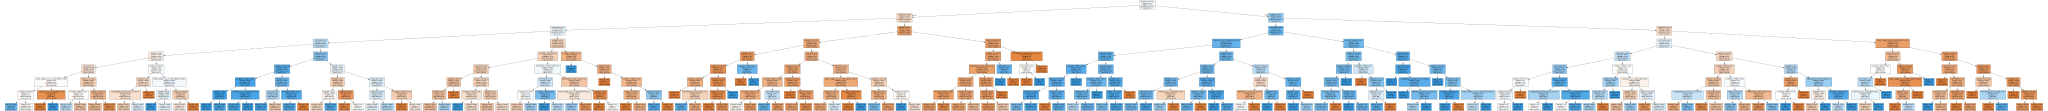

In [116]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = tree.export_graphviz(decision_tree, out_file=None, feature_names=predictor_cols, class_names=np.array(sorted(df['LEAVE'].unique())).astype('str').tolist(), filled=True)
graph = graphviz.Source(dot_data, format='png')
graph
# I've gotten an error every single time that I try to use graphviz; it won't accept a string but also can't use anything but a string.

In [122]:
from sklearn import metrics
print('Accuracy = %.3f' % (metrics.accuracy_score(decision_tree.predict(df[predictor_cols]),df['LEAVE'],)))

Accuracy = 0.726


In [ ]:
# Attempting to create the visualization using the code she gave us. Didn't succeed.

from IPython.display import Image
from sklearn.tree import export_graphviz

def visualize_tree(decision_tree, feature_names, class_names, directory='MacHD/Users/james/TIM147/Personal', name='tree',proportion=True):
    # Export to graphviz format
    dot_name = '%s/%s.png' % (directory, name)
    dot_file = export_graphviz(decision_tree, out_file=dot_name,
                               feature_names=feature_names, class_names=class_names, proportion=proportion)
    # Make image file from decision tree
    image_name = '%s.%s.png' % (directory, name)
    os.system('dot -T png %s -o %s' % (dot_name, image_name))
    # Return .png
    return Image(filename=image_name)

visualize_tree(decision_tree, predictor_cols, df['LEAVE'])

In [71]:
from sklearn.tree import DecisionTreeClassifier

predictor_cols = ['COLLEGE','REPORTED_SATISFACTION','REPORTED_USAGE_LEVEL','CONSIDERING_CHANGE_OF_PLAN',
                  'INCOME','OVERAGE','LEFTOVER','HOUSE','HANDSET_PRICE','OVER_15MINS_CALLS_PER_MONTH','AVERAGE_CALL_DURATION']
decision_tree = DecisionTreeClassifier(criterion='gini', max_depth=)
decision_tree.fit(df[predictor_cols],df['LEAVE'])

DecisionTreeClassifier(max_depth=6)